# Characterising Farm Dams

In this notebook we'll try and characterise farm dams by their time series. We have a collection of waterbodies I've labelled as farm dams or not, as well as the [Victorian farm dam dataset](https://data.gov.au/dataset/ds-dga-abdca916-8362-456e-aa36-7a3a852d0aa0/), and we'll have a look at their time series. Results may not generalise across Australia.

In [212]:
import sys
from pathlib import Path

import geohash
import geopandas as gpd
import h5py
import numpy as np
import shapely
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, plot_confusion_matrix
from tqdm.notebook import tqdm
import datacube
from sklearn.neighbors import KDTree
import palettable
from xgboost_tuner.tuner import tune_xgb_params  # https://github.com/chengsoonong/xgboost-tuner

sys.path.insert(1, "../Scientific_workflows/DEAWaterbodies/DEAWaterbodiesToolkit")
import dea_waterbodies
sys.path.insert(1, "../Scripts")
import dea_plotting

%matplotlib inline

In [3]:
wbs = gpd.read_file('waterbodies_joined_drainage_basins.shp').to_crs('EPSG:3577')

Load farm dams.

In [4]:
myfarmdams = gpd.read_file("allfarmdams.geojson")
mynotfarmdams = gpd.read_file("allnotfarmdams.geojson")

In [5]:
vicfarmdams = gpd.read_file('vic_farm_dams.shp')

In [6]:
vicfarmdams.FTYPE.unique()

array(['Rural Storage', 'Rural Irrigation Storage', 'Town Rural Storage',
       'Rural Licensed Storage', 'Industrial Storage', 'Settling Ponds',
       'Flood Irrigation Storage', 'Settling Pond', 'Aquaculture Area',
       'Aquiculture Area', 'Waste Water'], dtype=object)

In [29]:
wbs_vicfarmdams = gpd.sjoin(wbs, vicfarmdams.to_crs('EPSG:3577'), how='inner', op='intersects')

Load all other history data.

In [30]:
history_file = h5py.File("interpolated_waterbodies_by_division_and_basin_fixed.h5", "r")

In [31]:
dates = gpd.pd.DatetimeIndex(
    [a.decode("ascii") for a in history_file["dates"][()]], tz="UTC"
)

In [32]:
all_uids = myfarmdams.UID.append(mynotfarmdams.UID).append(wbs_vicfarmdams.UID)

Let's export the farm dams to a GeoJSON of points so we can load them into DEA Maps. This will have to be pretty small as it has to go in the browser.

In [33]:
for_output = wbs_vicfarmdams[['UID', 'FEATURETYP', 'FTYPE']]

In [34]:
for_output = for_output.copy()

In [35]:
for_output['geometry'] = wbs_vicfarmdams.centroid

In [36]:
gpd.GeoDataFrame(for_output).to_file('wbs_vicfarmdams.geojson', driver='GeoJSON')

From eyeballing this, we can see that Town Rural Storage are not generally farm dams, while Rural Storage generally are.

Maybe we could treat this as a multi-class problem, classifying as one of the following:

In [39]:
gpd.pd.unique(wbs_vicfarmdams.FTYPE)

array(['Town Rural Storage', 'Rural Storage', 'Rural Licensed Storage',
       'Settling Pond', 'Rural Irrigation Storage',
       'Flood Irrigation Storage', 'Industrial Storage', 'Settling Ponds',
       'Waste Water', 'Aquaculture Area'], dtype=object)

But surely binary is easier to think about. At any rate, these are all artificial waterodies, so we can do classification for that.

## A negative set for Victorian farm dams

We have lots of examples of Victorian farm dams, but what about Victorian waterbodies that aren't farm dams? Let's assume that unlabelled waterbodies in Victoria are not farm dams, and use them as the negative set.

States and territories shapefile: https://www.abs.gov.au/ausstats/abs@.nsf/PrimaryMainFeatures/1259.0.30.001?OpenDocument

In [49]:
states = gpd.read_file('STE11aAust.shp')

In [58]:
victoria = gpd.GeoDataFrame([states.set_index('STATE_NAME').loc['Victoria']])

In [63]:
victoria.crs = 'EPSG:4326'

In [40]:
unlabelled = wbs.set_index('UID').loc[sorted(set(wbs.UID) - set(all_uids))]

In [64]:
wbs_vicnotfarmdams = gpd.sjoin(victoria.to_crs('EPSG:3577'), unlabelled, op='contains')

In [68]:
wbs_vicnotfarmdams = wbs_vicnotfarmdams.set_index('index_right')

In [71]:
wbs_vicnotfarmdams['UID'] = wbs_vicnotfarmdams.index

In [72]:
all_uids = myfarmdams.UID.append(mynotfarmdams.UID).append(wbs_vicfarmdams.UID).append(wbs_vicnotfarmdams.UID)

In [73]:
time_series = {}
wbsi = wbs.set_index('UID')
for uid in tqdm(all_uids):
    division = wbsi.loc[uid].Division_
    if not division:
        continue
    basin = wbsi.loc[uid].BNAME or 'NONE'
    basin_uids = list(history_file[division][basin]['uid'][()])
    time_series[uid] = history_file[division][basin]['pc_wet'][basin_uids.index(uid.encode('ascii'))]

In [74]:
time_series = gpd.pd.DataFrame(time_series)

In [75]:
farmdam_uids = sorted(set(myfarmdams.UID.append(wbs_vicfarmdams.UID)) & set(time_series.columns))
notfarmdam_uids = sorted(set(mynotfarmdams.UID.append(wbs_vicnotfarmdams.UID)) & set(time_series.columns))

In [76]:
all_uids = notfarmdam_uids + farmdam_uids

In [77]:
labels = time_series.columns.isin(farmdam_uids)

## First day observed

What is the first day with non-zero surface area for these waterbodies? I imagine that many farm dams would have been constructed since 1985.

In [89]:
first_day_observed = np.argmax((time_series > 0).values, axis=0)

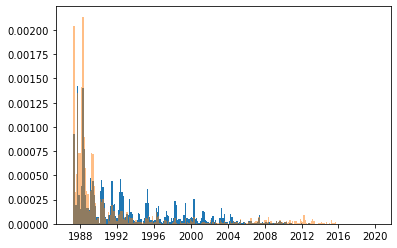

In [101]:
bins = np.arange(np.datetime64('1987-01-01').astype('datetime64[D]'), np.datetime64('2020-01-01').astype('datetime64[D]'), 50)
plt.hist(dates[first_day_observed[labels]], bins=bins, density=True)
plt.hist(dates[first_day_observed[~labels]], bins=bins, density=True, alpha=0.5);

We need a time-independent way to represent these waterbodies from the time of their first observation. We'll try SAD curves.

In [108]:
sads = []
for fdo, ts in zip(tqdm(first_day_observed), time_series.T.values):
    sad = np.sort(ts[fdo:])[::-1]
    sad = np.interp(np.linspace(0, 1, 300), np.linspace(0, 1, len(sad)), sad)
    sads.append(sad)

In [109]:
# sads = time_series.reset_index(drop=True).apply(lambda x: x.sort_values().values[::-1])

In [110]:
sads = np.array(sads)

In [114]:
sads = gpd.pd.DataFrame(sads, index=time_series.columns)

## Time series plots for farm dams and non-dams
Let's plot the SAD curves for farm dams and non-dams.

In [116]:
sads[labels]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
r6cvk3e1x,100.000,99.195234,97.750000,97.000000,96.750000,95.812500,94.812500,93.875000,92.968436,91.875000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r6cve8yeh,100.000,98.907400,96.192099,94.166597,91.687500,89.625000,87.500000,85.414298,83.312500,83.312500,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r6cvect2b,100.000,98.750000,97.062500,95.417851,93.750000,93.312500,93.312500,93.312500,93.312500,93.312500,...,1.674805,1.166519,0.582879,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r6cv6tjzp,100.000,100.000000,98.437500,96.875000,95.375000,93.812500,93.812500,93.812500,93.812500,93.441054,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r6cv72b1y,100.000,100.000000,99.202968,96.687500,92.812500,88.437500,84.046405,80.620819,77.437500,74.441054,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r1qszfbym,96.625,94.000000,92.687500,92.125000,91.574624,91.000000,90.518186,89.937500,89.687500,89.496028,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1qsvk6d5,100.000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1qsw0yme,100.000,100.000000,100.000000,100.000000,100.000000,98.415343,96.630853,94.562500,92.903637,91.500000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r1qsuy6b3,100.000,98.040343,94.812500,91.746028,88.764214,85.948161,83.312500,83.312500,83.312500,83.312500,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Not farm dams')

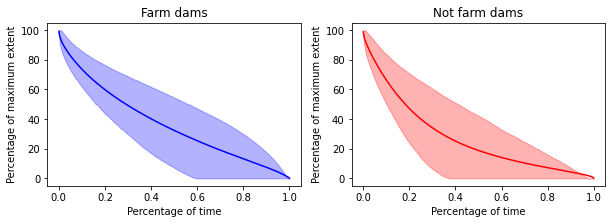

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# sads[labels].plot(c="k", alpha=0.01, ax=axs[0], legend=False)
# sads[labels].plot(c="k", alpha=0.01, ax=axs[1], legend=False)
xs = np.linspace(0, 1, 300)
mean = np.nanmean(sads[labels], axis=0)
low, high = np.nanpercentile(sads[labels], [16, 84], axis=0)
axs[0].plot(xs, mean, c="blue")
axs[0].fill_between(xs, low, high, color='blue', alpha=0.3)
mean = np.nanmean(sads[~labels], axis=0)
low, high = np.nanpercentile(sads[~labels], [16, 84], axis=0)
axs[1].plot(xs, mean, c="red")
axs[1].fill_between(xs, low, high, color="red", alpha=0.3)
for ax in axs:
    ax.set_xlabel("Percentage of time")
    ax.set_ylabel("Percentage of maximum extent")
axs[0].set_title("Farm dams")
axs[1].set_title("Not farm dams")

Farm dams seem to empty slower than non-dams. Non-dams also have a much wider tail. Let's try subdividing this by type of farm dam.

Text(0.5, 1.0, 'Average surface area duration')

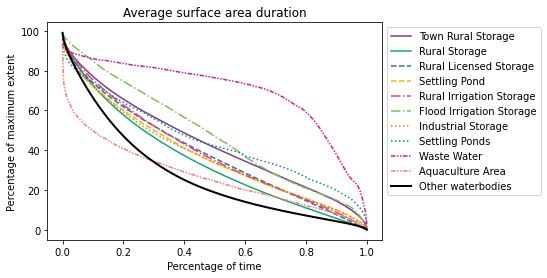

In [173]:
colours = palettable.cartocolors.qualitative.Bold_10.mpl_colors
linestyles = ['-', '-', '--', '--', '-.', '-.', ':', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1))]
fig, ax = plt.subplots()
for i, ftype in enumerate(gpd.pd.unique(wbs_vicfarmdams.FTYPE)):
    uids = sorted((set(wbs_vicfarmdams.UID[wbs_vicfarmdams.FTYPE == ftype]) & set(sads.index)))
    xs = np.linspace(0, 1, 300)
    mean = np.nanmean(sads.loc[uids], axis=0)
    low, high = np.nanpercentile(sads.loc[uids], [16, 84], axis=0)
    ax.plot(xs, mean, c=colours[i], alpha=1, label=ftype, linestyle=linestyles[i])
#     ax.fill_between(xs, low, high, color=colours[i])
mean = np.nanmean(sads[~labels], axis=0)
ax.plot(xs, mean, c="k", linewidth=2, label='Other waterbodies')
ax.set_xlabel("Percentage of time")
ax.set_ylabel("Percentage of maximum extent")
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title('Average surface area duration')

Most dam types seem to follow the same kind of curve on average, with waste water and aquaculture significantly deviating. Aquaculture very rapidly drains, and waste water very slowly drains.

## SAD features for farm dam classification?

We previously generated representations of waterbodies using SAD curves (`SADRepresentation.ipynb`). Can we use this with a simple classifier?

Note: tried a KNN on the raw SAD curves, it was terrible.

In [176]:
sad_repr = {}
wbsi = wbs.set_index('UID')
for uid in tqdm(all_uids):
    division = wbsi.loc[uid].Division_
    if not division:
        continue
    basin = wbsi.loc[uid].BNAME or 'NONE'
    basin_uids = list(history_file[division][basin]['uid'][()])
    sad_repr[uid] = history_file[division][basin]['sad_features'][basin_uids.index(uid.encode('ascii'))]

In [184]:
sad_representations = gpd.pd.DataFrame(sad_repr).T

In [185]:
train_uids, test_uids = train_test_split(sorted(set(all_uids) & set(sad_representations.index)), random_state=0, test_size=0.4)

In [186]:
train_features = sad_representations.loc[train_uids]
test_features = sad_representations.loc[test_uids]

In [205]:
# clf = Pipeline([('scale', StandardScaler()), ('classifier', LogisticRegression(solver='liblinear'))])
# clf = Pipeline([('scale', StandardScaler()), ('classifier', RandomForestClassifier(max_depth=6))])

In [206]:
labels = gpd.pd.DataFrame(np.zeros(len(all_uids), dtype=bool), index=all_uids)
labels.loc[farmdam_uids] = True

In [214]:
train_labels = labels.loc[train_uids].values.ravel()

In [215]:
test_labels = labels.loc[test_uids].values.ravel()

In [227]:
best_params, history = tune_xgb_params(
    train=train_features,
    label=train_labels,
    cv_folds=3,
    metric_sklearn='accuracy',
    metric_xgb='error',
    n_jobs=2,
    objective='binary:logistic',
    random_state=0,
    strategy='randomized',
    n_iter=1000,
)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[12:56:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only u

OSError: [Errno 12] Cannot allocate memory

In [218]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (89 entries)


In [207]:
clf.fit(np.nan_to_num(train_features), labels.loc[train_uids].values.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(max_depth=6))])

In [208]:
clf.score(np.nan_to_num(test_features), labels.loc[test_uids].values.ravel())

0.7285481648503069

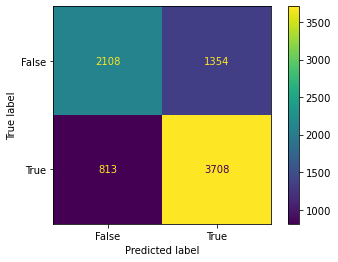

In [209]:
plot_confusion_matrix(clf, np.nan_to_num(test_features), labels.loc[test_uids].values.ravel())

We can see from the confusion matrix that we are getting too many farm dams (with random forests) or too few farm dams (with logistic regression).

Let's get 50 objects in the MDB that the classifier is uncertain (or very certain?) about.

In [397]:
uncertain = sad_representations.index[abs(clf.predict_proba(sad_representations)[:, 1] - 0.5).argsort()][:51]
# uncertain = sad_representations.index[abs(clf.predict_proba(sad_representations)[:, 1] - 0.5).argsort()[::-1]][:52]

In [398]:
uncertain = sorted(set(uncertain) - set(all_uids))
len(uncertain)

50

Export these as GeoJSON.

In [ ]:
wbs.set_index('UID').loc[uncertain].to_file('uncertain.geojson', driver='GeoJSON')

Label them in QGIS and load back in.

In [358]:
certain = gpd.read_file('uncertain (4).geojson')

In [360]:
# certain = certain.reset_index().rename(columns={'index': 'UID'})

In [361]:
farmdams = farmdams.append(certain[gpd.pd.notnull(certain.farmdam)])

In [362]:
notfarmdams = notfarmdams.append(certain[gpd.pd.isnull(certain.farmdam)])

In [363]:
farmdams.to_file('allfarmdams.geojson', driver='GeoJSON')

In [364]:
notfarmdams.to_file('allnotfarmdams.geojson', driver='GeoJSON')

## Self-training

Can we boost our performance by self-training on the unlabelled data?

In [165]:
self_training_uids = list(train_uids)

In [166]:
self_training_labels = list(labels.loc[train_uids].values.ravel())

In [167]:
unlabelled = sorted(set(sad_representations.index) - set(all_uids))

In [168]:
len(unlabelled)

23234

In [169]:
sad_representations[gpd.pd.isnull(sad_representations)] = 0

In [170]:
n_epochs = 1000
bar = tqdm(total=n_epochs)
for i in range(n_epochs):
    # Train on the self-training dataset.
    clf.fit(sad_representations.loc[self_training_uids], self_training_labels)
    # Predict probabilities on this dataset.
    probs = clf.predict_proba(sad_representations.loc[unlabelled])[:, 1]
    # Then take the most probable (negative or positive).
    most_probable_idx = abs(0.5 - probs).argmax()
    most_probable_uid = unlabelled[most_probable_idx]
    # Add this to the training set.
    self_training_labels.append(probs[most_probable_idx] > 0.5)
    self_training_uids.append(most_probable_uid)
    unlabelled.remove(most_probable_uid)
    # Re-score.
    score = clf.score(sad_representations.loc[test_uids], labels.loc[test_uids])
    bar.postfix = ' {:.02%}'.format(score)
    bar.update(1)
    # Then retrain...

KeyboardInterrupt: 

That was slightly helpful.

Now let's run this on the entire Moonie River.

In [205]:
moonie_predictions = clf.predict(gpd.pd.DataFrame(
        history_file["Murray-Darling Basin"]['MOONIE RIVER']["sad_features"], index=uids['MOONIE RIVER']
    ))

In [212]:
moonie = wbs.set_index('UID').loc[uids['MOONIE RIVER']]

In [213]:
moonie['farm_dam_prediction'] = moonie_predictions

In [214]:
moonie.to_file("predictions.geojson", driver="GeoJSON")

## Examining the dam/non-dam sets

Let's look at aerial imagery for these objects using Sentinel 2.

In [144]:
dc = datacube.Datacube()

In [137]:
rand_uids = np.copy(farmdam_uids)
np.random.shuffle(rand_uids)

In [140]:
g = wbs.set_index('UID').loc[rand_uids].geometry

In [141]:
def get_image(wb, ax=None):
    ds = dc.load('s2a_ard_granule', time='2019-01', geopolygon=datacube.utils.geometry.Geometry(wb.geometry.convex_hull.buffer(100), crs='EPSG:3577'),
        output_crs='EPSG:3577', resolution=(-10, 10), group_by='solar_day', measurements=['nbart_red', 'nbart_green', 'nbart_blue'])
    if ax is None:
        fig, ax = plt.subplots()
    dea_plotting.rgb(ds.isel(time=0), ax=ax)
    gpd.GeoDataFrame([0], geometry=[wb.geometry]).plot(ax=ax, facecolor='None', edgecolor='blue')
    ax.axis('off')
    ax.set_title('')
    return ds

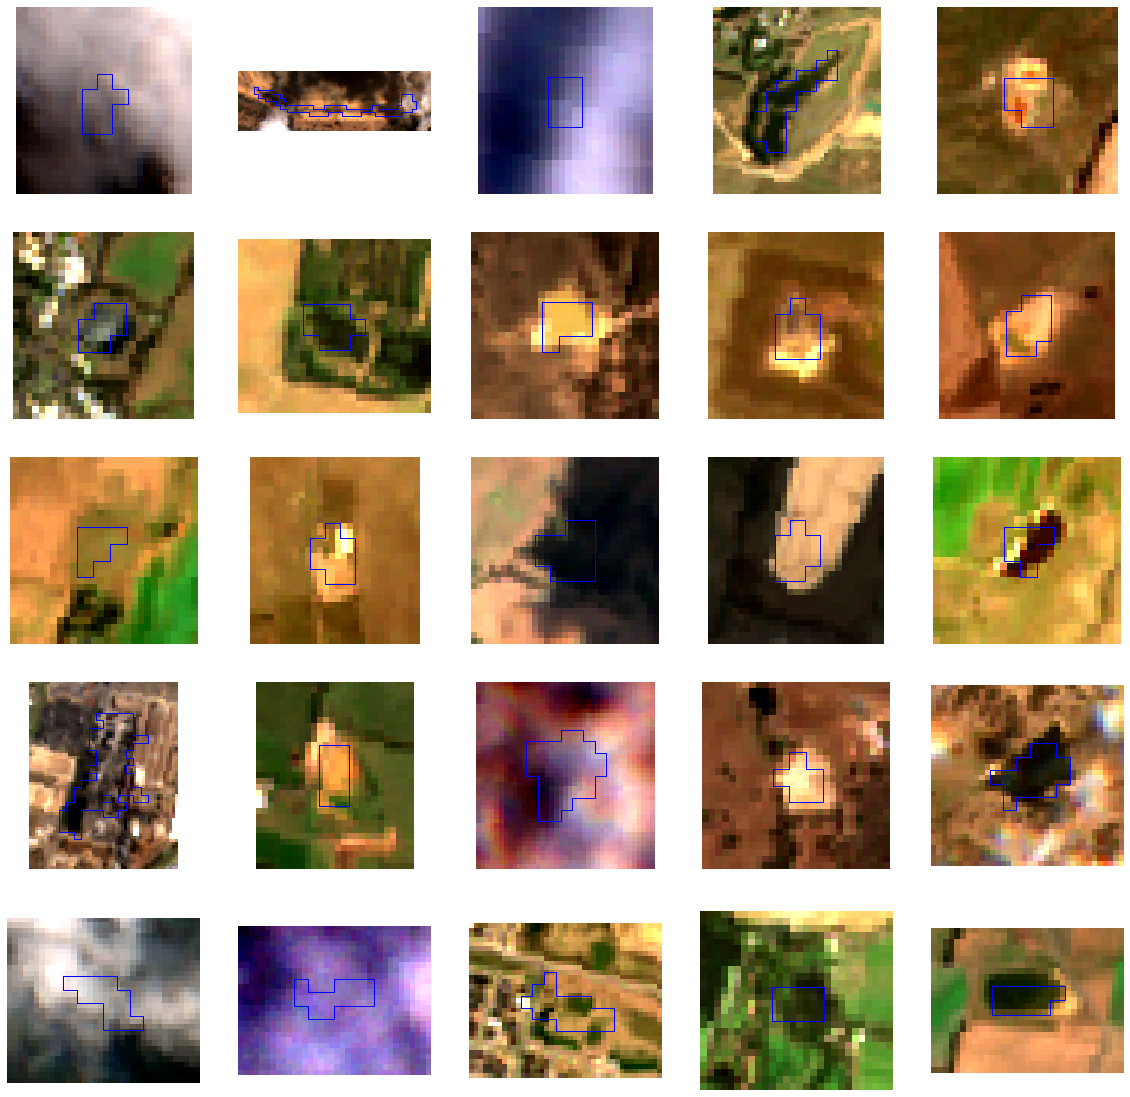

In [145]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i in tqdm(range(25)):
    ax = axs[i % 5][i // 5]
    get_image(wbs.set_index('UID').loc[rand_uids[i]], ax=ax)